# Imports

In [1]:
import torch.nn as nn
import torch

from datetime import datetime
import models.SANet as SANet
import utils.data as data
from utils.eval import compute_ssim, plot_results
from utils.fid import calculate_fid_from_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and Dataloaders

In [2]:
import torchvision.transforms as transforms

val_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

_, content_validloader, _, _, style_validloader, _ = data.get_dataloaders(bs=64, valid_tf=val_tf)


# Model Evaluation Functions

## a) Quantitative

To evaluate model performance quantitatively, we compute the structural similarity (SSIM), the inference time and the content and style loss.


In [3]:
# Code below has been adapted from https://github.com/EndyWon/MicroAST/blob/main/metrics/calc_cs_loss.py
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def calc_content_loss(input, target):
    assert (input.size() == target.size())
    return torch.nn.MSELoss()(input, target)

def calc_style_loss(input, target):
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    return torch.nn.MSELoss()(input_mean, target_mean) + torch.nn.MSELoss()(input_std, target_std)

def compute_style_loss(style_images, stylised_images, net):
    """Compute the style loss between the style images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    loss_s = 0.0
    output1_1 = enc_1(style_images)
    style1_1 = enc_1(stylised_images) 
    loss_s += calc_style_loss(output1_1, style1_1)
    
    output2_1 = enc_2(output1_1)
    style2_1 = enc_2(style1_1)
    loss_s += calc_style_loss(output2_1, style2_1)

    output3_1 = enc_3(output2_1)
    style3_1 = enc_3(style2_1)
    loss_s += calc_style_loss(output3_1, style3_1)

    output4_1 = enc_4(output3_1)
    style4_1 = enc_4(style3_1)
    loss_s += calc_style_loss(output4_1, style4_1)

    output5_1 = enc_5(output4_1)
    style5_1 = enc_5(style4_1)
    loss_s += calc_style_loss(output5_1, style5_1)
    
    return float(loss_s / 5)
        
def compute_content_loss(content_images, stylised_images, net):
    """Compute the content loss between the content images and stylised images"""
    enc_1 = net[0]
    enc_2 = net[1]
    enc_3 = net[2]
    enc_4 = net[3]
    enc_5 = net[4]
    
    loss_c = 0.0

    output1 = enc_4(enc_3(enc_2(enc_1(content_images))))
    content1 = enc_4(enc_3(enc_2(enc_1(stylised_images))))

    loss_c += calc_content_loss(output1, content1)
    
    output2 = enc_5(output1)
    content2 = enc_5(content1)
    
    loss_c += calc_content_loss(output2, content2)
        
    return float(loss_c / 2)

# Load pretrained model

In [4]:
decoder = SANet.decoder
vgg = SANet.vgg
transform = SANet.Transform(in_planes=512)
decoder.load_state_dict(torch.load('./models/output/decoder_iter_500000.pth'))
vgg.load_state_dict(torch.load('./models/output/vgg_normalised.pth'))
transform.load_state_dict(torch.load('./models/output/transformer_iter_500000.pth'))

<All keys matched successfully>

# Run model evaluation

In [5]:
def SANet_eval(decoder, vgg, transform, content_loader, style_loader):
    decoder.eval()
    transform.eval()
    vgg.eval()

    enc_1 = nn.Sequential(*list(vgg.children())[:4])     # input -> relu1_1
    enc_2 = nn.Sequential(*list(vgg.children())[4:11])   # relu1_1 -> relu2_1
    enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
    enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
    enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

    enc_1.to(device)
    enc_2.to(device)
    enc_3.to(device)
    enc_4.to(device)
    enc_5.to(device)
    transform.to(device)
    decoder.to(device)
    
    with torch.no_grad():
        ssim_sum = 0.0
        total_samples = 0
        running_content_loss, running_style_loss = 0.0, 0.0
        running_inference_time = 0.0
        fid_sum = 0.0
        for content, style in zip(content_loader, style_loader):
            # Move content and style batches to device
            content_images = content
            content_images = content_images.to(device)
            
            style_images, style_labels = style
            style_images, style_labels = style_images.to(device), style_labels.to(device)
            
            start = datetime.now()
            
            # Create stylised images
            content4_1 = enc_4(enc_3(enc_2(enc_1(content_images))))
            content5_1 = enc_5(content4_1)

            style4_1 = enc_4(enc_3(enc_2(enc_1(style_images))))
            style5_1 = enc_5(style4_1)

            stylised_images = decoder(transform(content4_1, style4_1, content5_1, style5_1))
            stylised_images.clamp(0, 255)
            
            # Running inference time in seconds
            running_inference_time += (datetime.now() - start).total_seconds()

            # Display qualitative evaluation metrics on first batch
            if total_samples == 0:
                plot_results(content_images, style_images, style_labels, stylised_images, nrows=5, model_name="SANet")

            # Compute quantitative evaluation metrics
            ssim_sum += compute_ssim(content_images, stylised_images)
            running_content_loss += compute_content_loss(content_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            running_style_loss += compute_style_loss(style_images, stylised_images, [enc_1, enc_2, enc_3, enc_4, enc_5])
            fid_sum += calculate_fid_from_dataset(content_images, stylised_images, device, 2048)
            
            total_samples += style_labels.size(0)
            
    avg_ssim = ssim_sum / total_samples
    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples
    avg_inference_time = running_inference_time / total_samples
    avg_fid = fid_sum / total_samples

    return avg_ssim, avg_content_loss, avg_style_loss, avg_inference_time, avg_fid
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


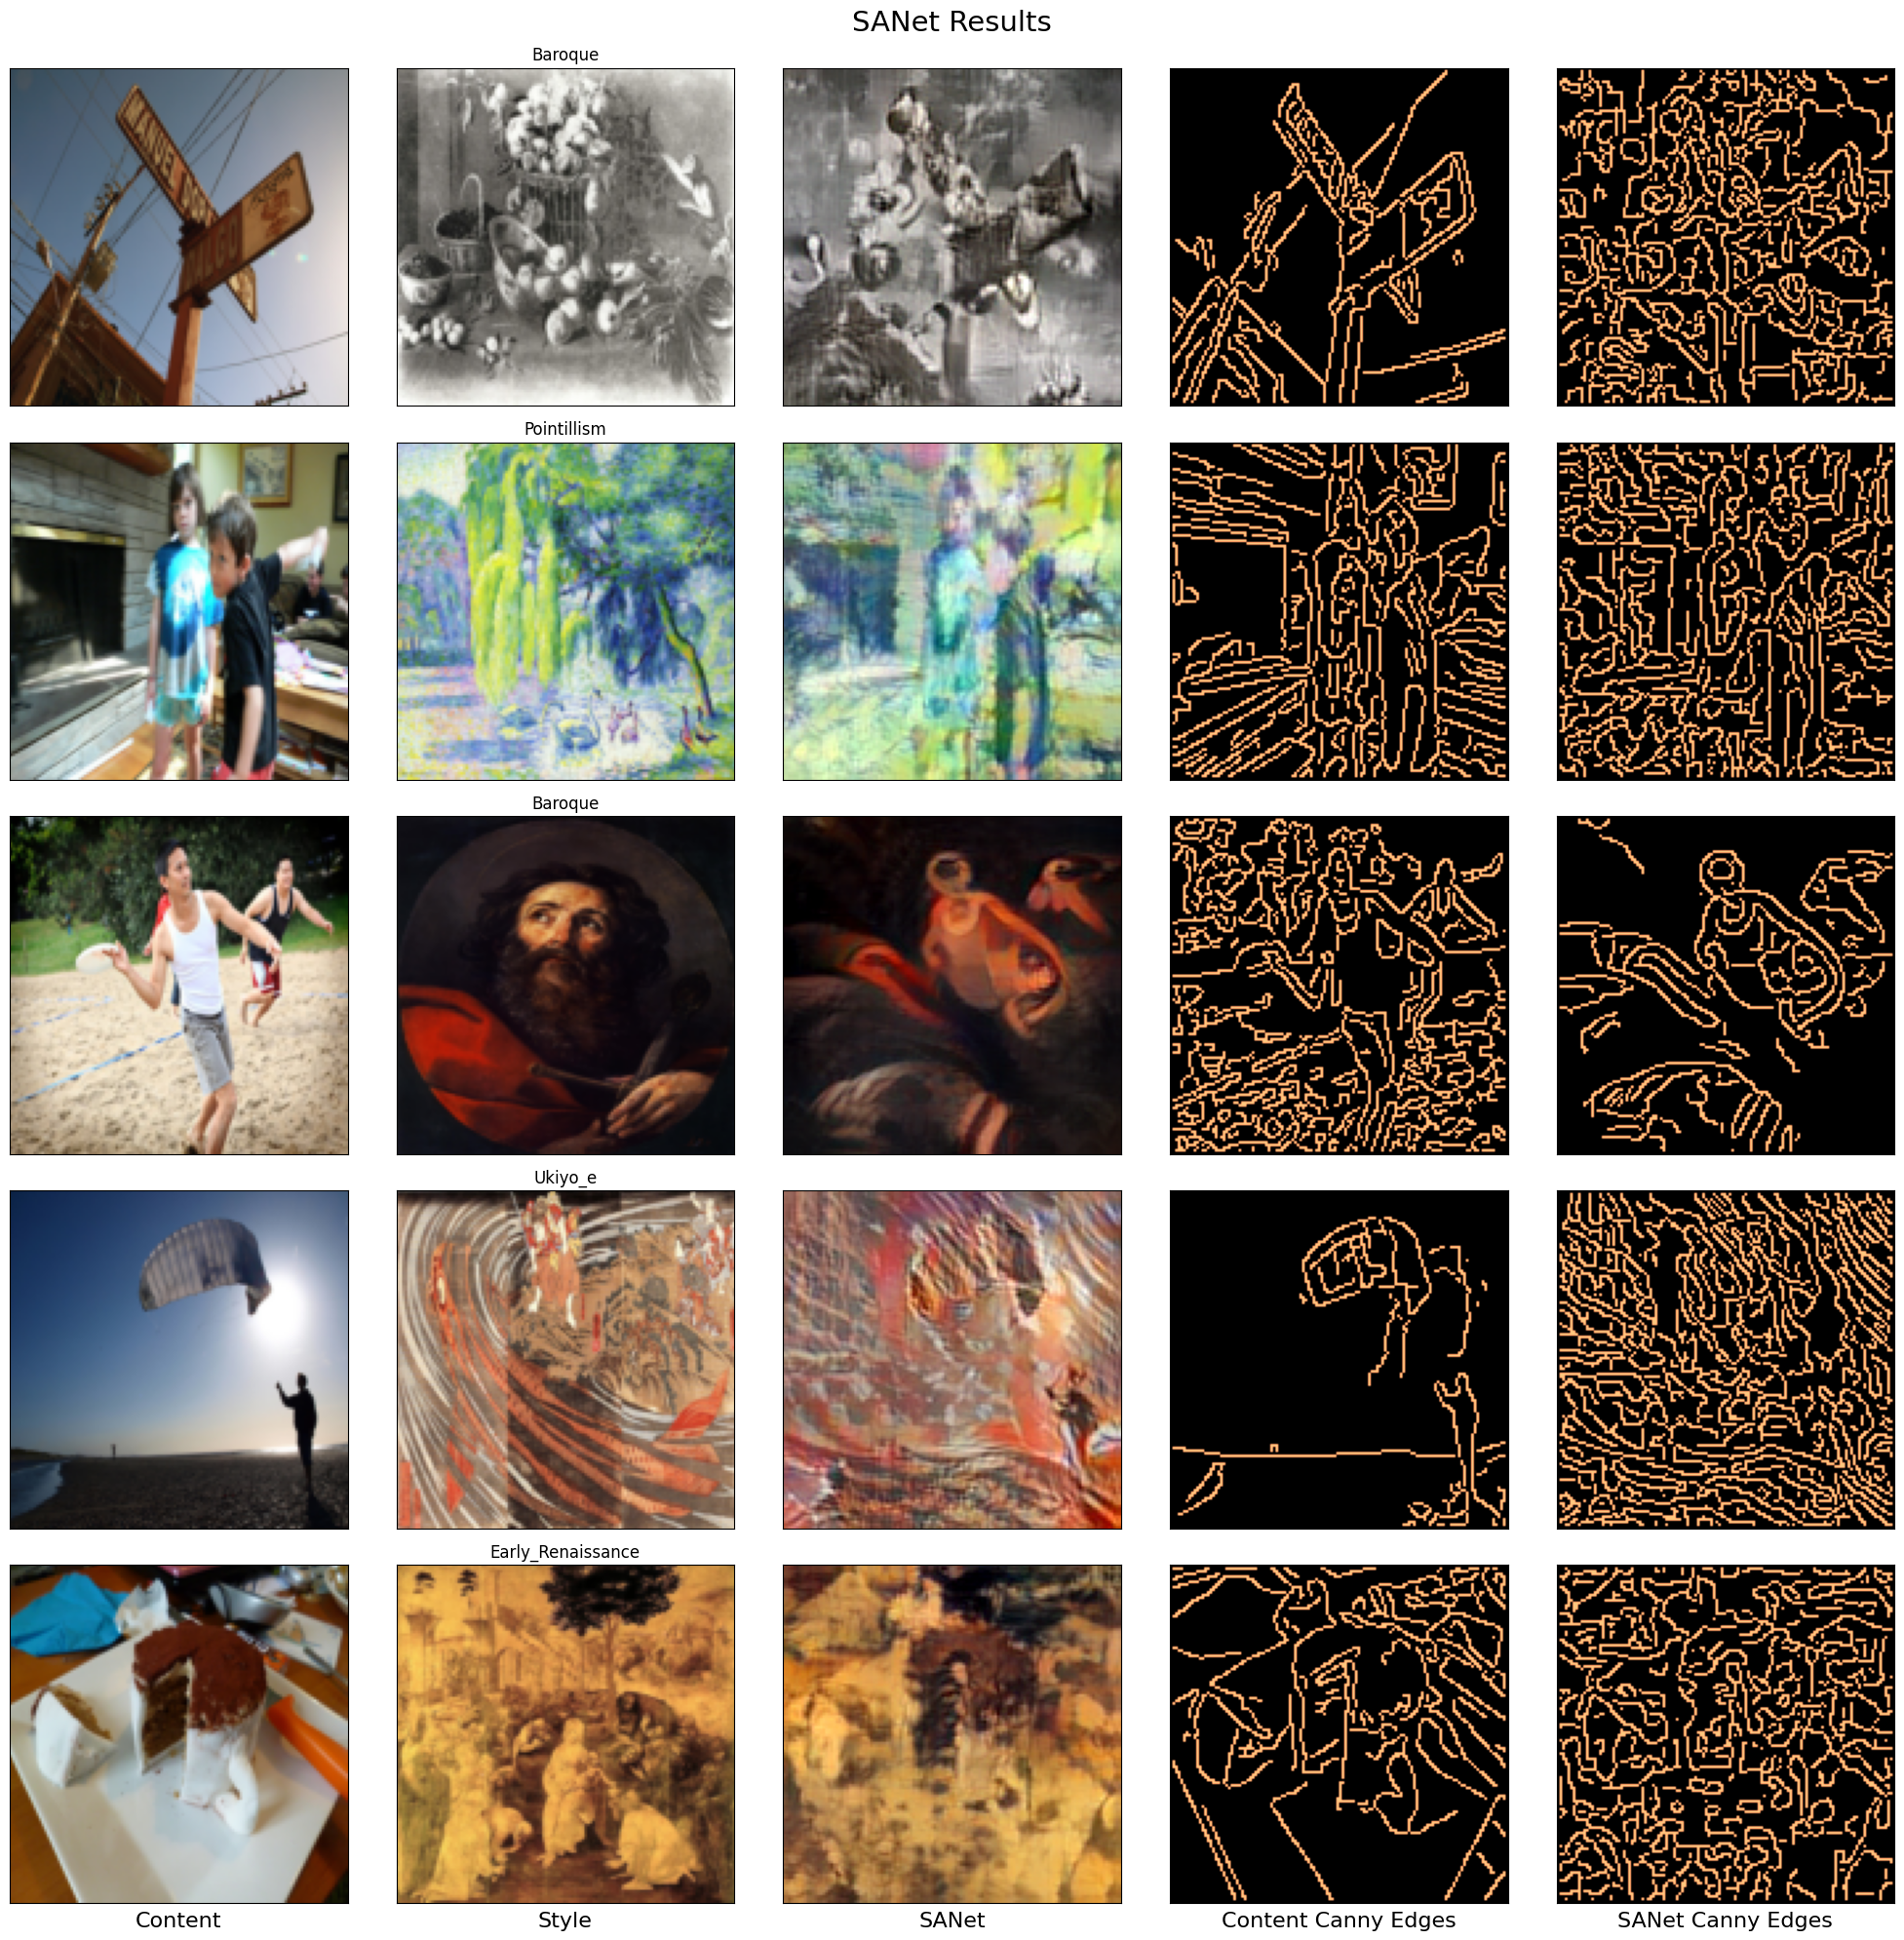

--- SANet results ---
Average SSIM = 0.2778
Average content loss = 0.0772
Average style loss = 0.0071
Average inference time = 0.0008 seconds


In [6]:
SANet_ssim, SANet_content_loss, SANet_style_loss, SANet_inference_time = SANet_eval(decoder, vgg, transform, content_validloader, style_validloader)
print("--- SANet results ---")
print(f"Average SSIM = {SANet_ssim:.4f}")
print(f"Average content loss = {SANet_content_loss:.4f}")
print(f"Average style loss = {SANet_style_loss:.4f}")
print(f"Average inference time = {SANet_inference_time:.4f} seconds")